Note! For a most up to date version of this notebook, make sure you copy from:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1wTMIrJhYsQdq_u7ROOkf0Lu_fsX5Mu8a)

## **Training MobileNetSSD Object Detection on a Custom Dataset**

💡 Recommendation: [Open this blog post](https://blog.roboflow.ai/training-a-tensorflow-object-detection-model-with-a-custom-dataset/) to continue.

### **Overview**

This notebook walks through how to train a MobileNet object detection model using the TensorFlow 1.5 Object Detection API.

In this specific example, we'll training an object detection model to recognize cells types: white blood cells, red blood cells and platelets. **To adapt this example to train on your own dataset, you only need to change two lines of code in this notebook.**

Everything in this notebook is also hosted on this [GitHub repo](https://github.com/josephofiowa/tensorflow-object-detection).

![Blood Cell Example](https://i.imgur.com/QwyX2aD.png)

**Credit to [DLology](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/) and [Tony607](https://github.com/Tony607)**, whom wrote the first notebook on which much of this is example is based. 

### **Our Data**

We'll be using an open source cell dataset called BCCD (Blood Cell Count and Detection). Our dataset contains 364 images (and 4888 annotations!) is hosted publicly on Roboflow [here](https://public.roboflow.ai/object-detection/bccd).

When adapting this example to your own data, create two datasets in Roboflow: `train` and `test`. Use Roboflow to generate TFRecords for each, replace their URLs in this notebook, and you're able to train on your own custom dataset.

### **Our Model**

We'll be training a MobileNetSSDv2 (single shot detector). This specific model is a one-short learner, meaning each image only passes through the network once to make a prediction, which allows the architecture to be very performant for mobile hardware.

The model arechitecture is one of many available via TensorFlow's [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models).

As a note, this notebook presumes TensorFlow 1.5 as TensorFlow 2.0 has yet to fully support the object detection API.

### **Training**

Google Colab provides free GPU resources. Click "Runtime" → "Change runtime type" → Hardware Accelerator dropdown to "GPU."

Colab does have memory limitations, and notebooks must be open in your browser to run. Sessions automatically clear themselves after 12 hours.

### **Inference**

We'll run inference directly in this notebook, and on three test images contained in the "test" folder from our GitHub repo. 

When adapting to your own dataset, you'll need to add test images to the `test` folder located at `tensorflow-object-detection/test`.

### **About**

[Roboflow](https://roboflow.ai) makes managing, preprocessing, augmenting, and versioning datasets for computer vision seamless.

Developers reduce 50% of their boilerplate code when using Roboflow's workflow, automate labelling quality assurance, save training time, and increase model reproducibility.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)







## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [ ]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'
num_image = 47
batch_size = 12
# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = int(4000 * (num_image / batch_size))  # 200000 to improve
print(num_steps)
# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    },    
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

15666


In [ ]:
# use TF 1.x for Object Detection APIs as they are not ported to TF 2.0 yet
%tensorflow_version 1.x
!pip install lvis

TensorFlow 1.x selected.


## Clone the `tensorflow-object-detection` repository or your fork.

In [ ]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.84 MiB | 38.53 MiB/s, done.
Resolving deltas: 100% (412/412), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


## Install required packages

In [ ]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
     |████████████████████████████████| 358kB 23.5MB/s 
Selecting previously unselected package python-bs4.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unp

## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [ ]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

/content/tensorflow-object-detection-faster-rcnn/data


In [ ]:
!curl -L "https://app.roboflow.com/ds/42mHtrpuCM?key=kDkfZygeb1" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   1500      0 --:--:-- --:--:-- --:--:--  1497
100 1166k  100 1166k    0     0  1417k      0 --:--:-- --:--:-- --:--:-- 1417k
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/sperm.tfrecord     
 extracting: test/sperm_label_map.pbtxt  
   creating: train/
 extracting: train/sperm.tfrecord    
 extracting: train/sperm_label_map.pbtxt  


In [ ]:
# training set
%ls train

sperm_label_map.pbtxt  sperm.tfrecord


In [ ]:
# test set
%ls test

sperm_label_map.pbtxt  sperm.tfrecord


In [ ]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/test/sperm.tfrecord'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/sperm.tfrecord'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/sperm_label_map.pbtxt'

## Download base model

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 24 root   root  4.0K Jan  1 05:17 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 2
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [ ]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-01-01 05:17:21--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.224.49.7, 54.145.36.98, 34.196.154.11, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.224.49.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  63.3MB/s    in 0.2s    

2021-01-01 05:17:21 (63.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


## Train the model

In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0101 05:17:26.954139 140268667012992 model_lib.py:793] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 15666
I0101 05:17:26.954342 140268667012992 config_util.py:552] Maybe overwriting train_steps: 15666
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0101 05:17:26.954438 140268667012992 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0101 05:17:26.954518 140268667012992 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0101 05:17:26.954597 140268667012992 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0101 05:17:26.954696 140268667012992 model_lib.py:809] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to

In [ ]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1609478261.aa06ee079388
export
graph.pbtxt
model.ckpt-12106.data-00000-of-00001
model.ckpt-12106.index
model.ckpt-12106.meta
model.ckpt-14525.data-00000-of-00001
model.ckpt-14525.index
model.ckpt-14525.meta
model.ckpt-15666.data-00000-of-00001
model.ckpt-15666.index
model.ckpt-15666.meta
model.ckpt-7272.data-00000-of-00001
model.ckpt-7272.index
model.ckpt-7272.meta
model.ckpt-9695.data-00000-of-00001
model.ckpt-9695.index
model.ckpt-9695.meta


## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [ ]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-15666
Instructions for updating:
Please use `layer.__call__` method instead.
W0101 06:23:20.471695 140261086836608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0101 06:23:22.555625 140261086836608 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0101 06:23:22.592728 140261086836608 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0101 06:23:22.628702 140261086836608 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:dep

In [ ]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [ ]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [ ]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 19M Jan  1 06:23 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [ ]:
from google.colab import files
files.download(pb_fname)

### OPTIONAL: Download the `label_map.pbtxt` file

In [ ]:
from google.colab import files
files.download(label_map_pbtxt_fname)

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
files.download(pipeline_fname)

NameError: ignored

In [ ]:
%cd {repo_dir_path}
!curl -L "https://app.roboflow.com/ds/W9xTc0Vb6f?key=8Ygv3z2MA3" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd data/test
%rm sperm.tfrecord
%rm sperm_label_map.pbtxt


[Errno 2] No such file or directory: '{repo_dir_path}'
/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   886  100   886    0     0    942      0 --:--:-- --:--:-- --:--:--   942
100 8766k  100 8766k    0     0  6631k      0  0:00:01  0:00:01 --:--:-- 75.9M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/image101_jpg.rf.0d2601ced0f844cf0a080adc3adb03d6.jpg  
 extracting: test/image101_jpg.rf.0d2601ced0f844cf0a080adc3adb03d6.xml  
 extracting: test/image102_jpg.rf.6b7887b8a6edd92043514e92e10ff9cf.jpg  
 extracting: test/image102_jpg.rf.6b7887b8a6edd92043514e92e10ff9cf.xml  
 extracting: test/image104_jpg.rf.a05398a5409f2fcb306be5ae7a6d2632.jpg  
 extracting: test/image104_jpg.rf.a05398a5409f2fcb306be5ae7a6d2632.xml  
 extracting: test/image105_jpg.rf.aa0fd37657f2c5173063c340cc1e99b0.jpg  
 extracting: test/image105_jp

## Run inference test
Test with images in repository `tensorflow-object-detection/test` directory.

**To test with your own images, you need to place your images inside the `test` directory in this Colab notebook!** More on this below.

In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

NameError: ignored

In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [ ]:
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib inline

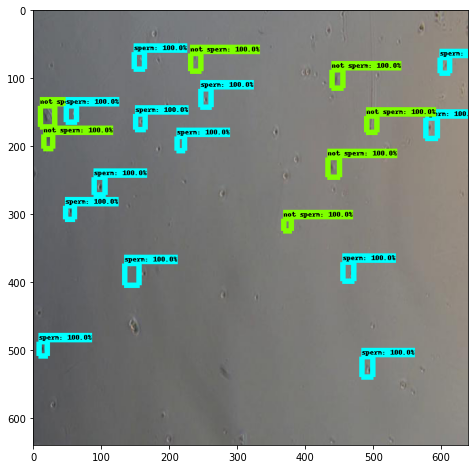

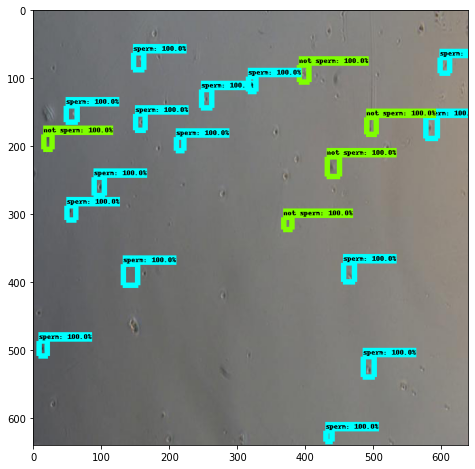

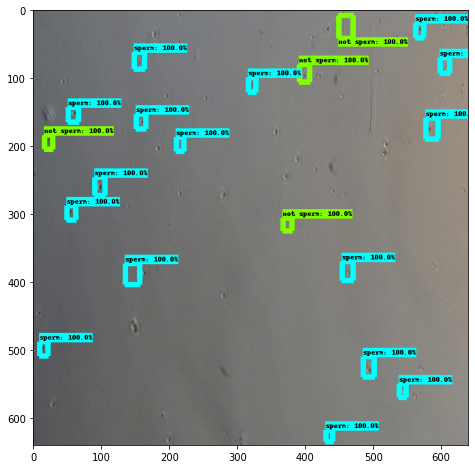

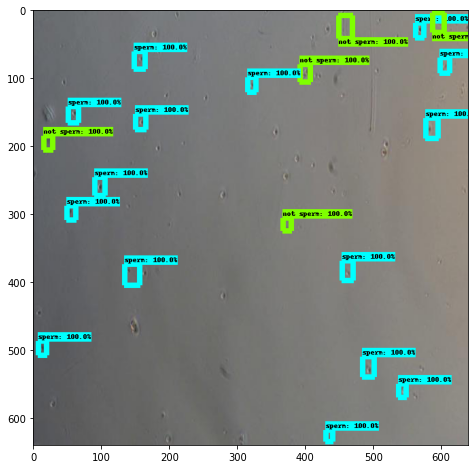

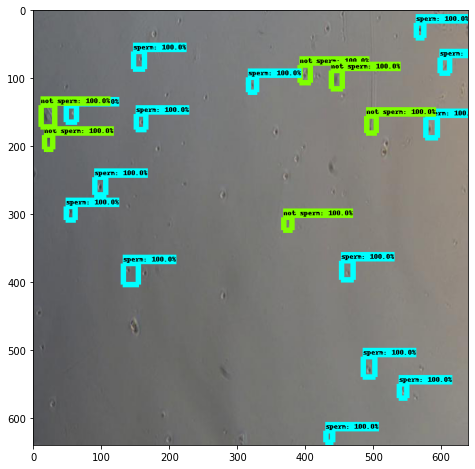

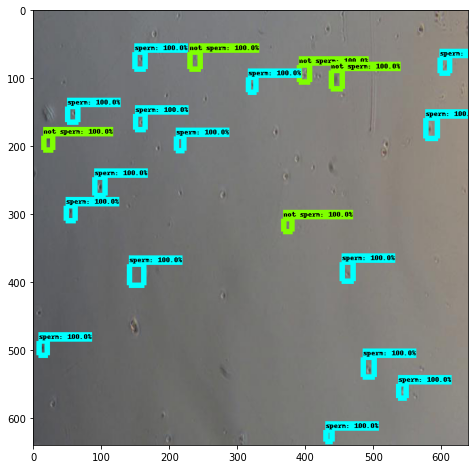

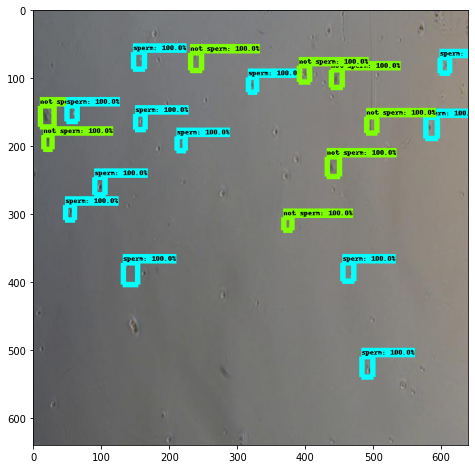

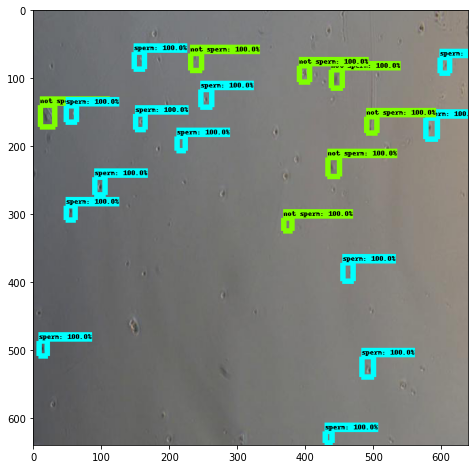

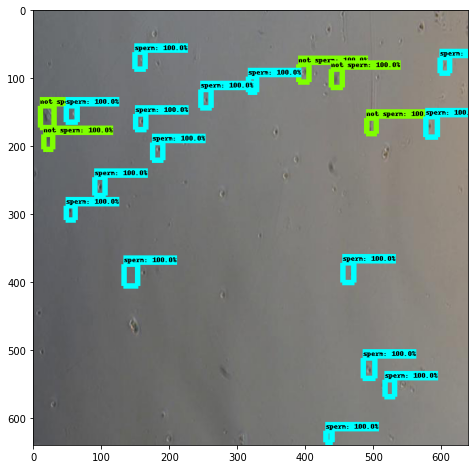

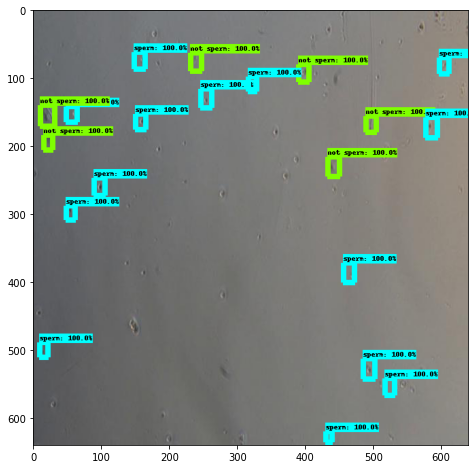

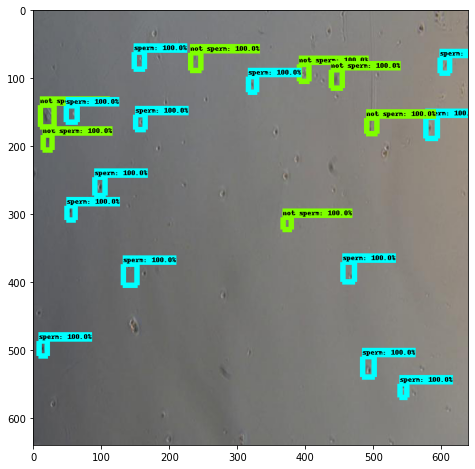

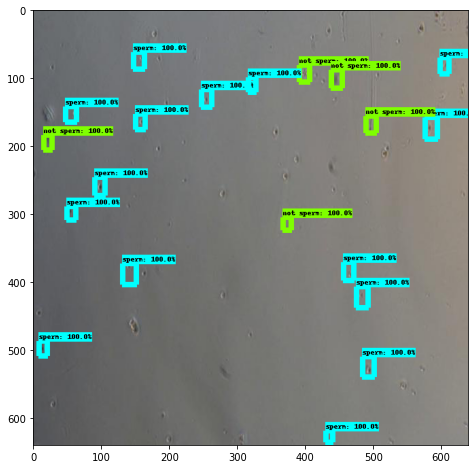

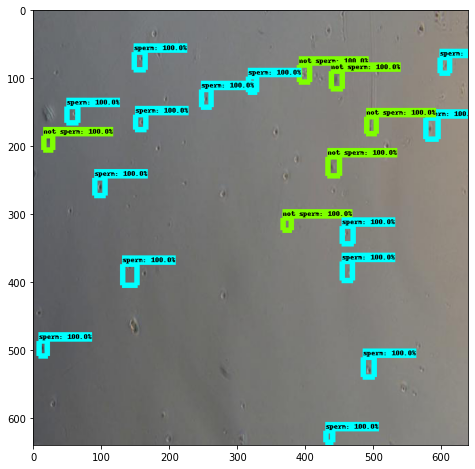

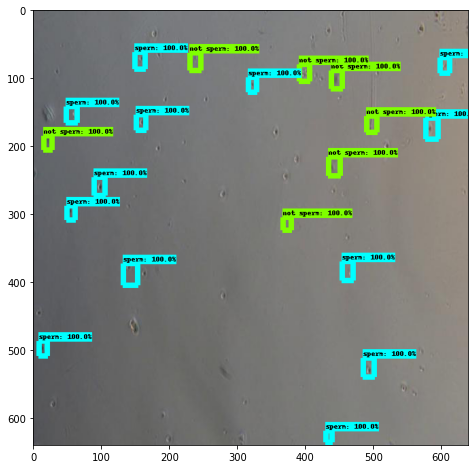

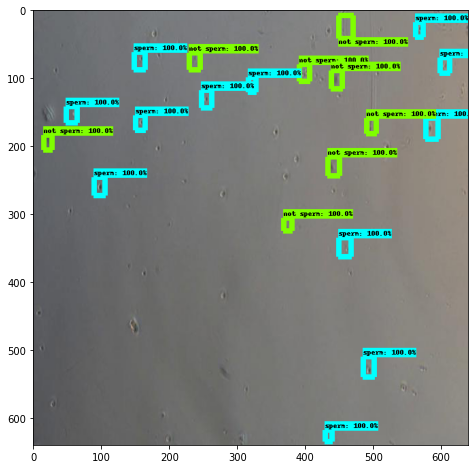

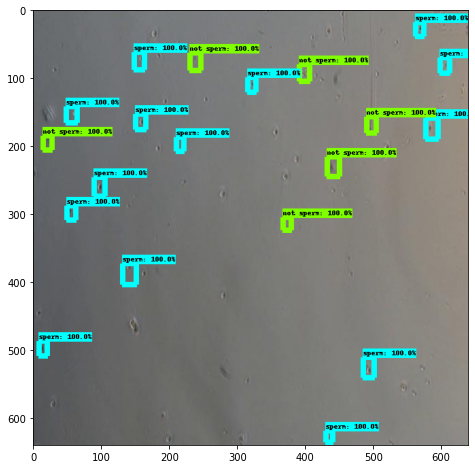

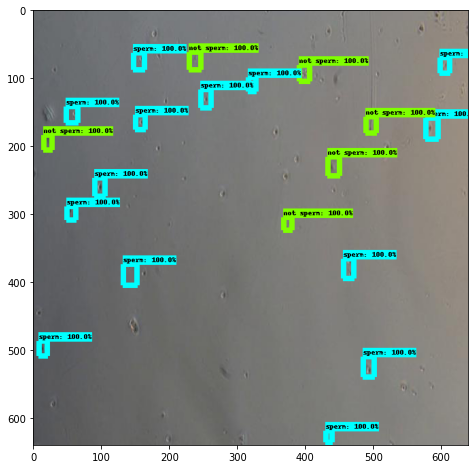

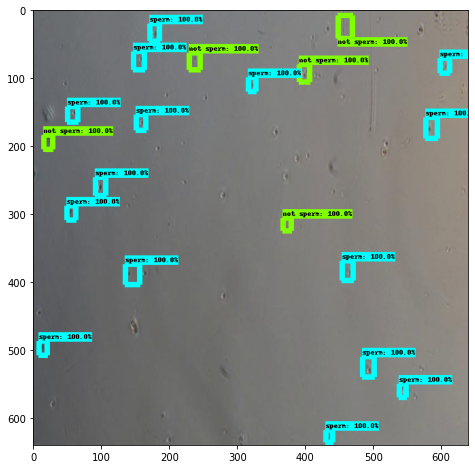

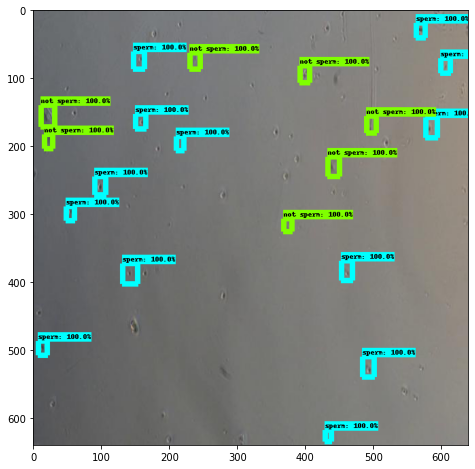

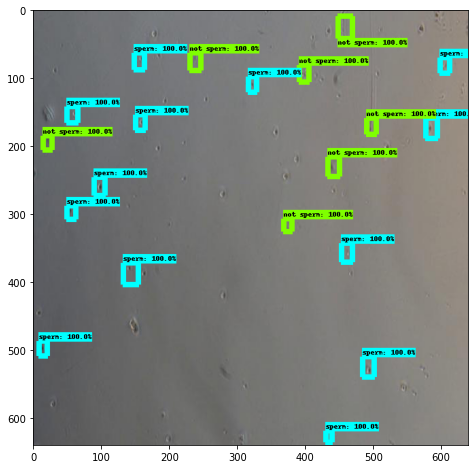

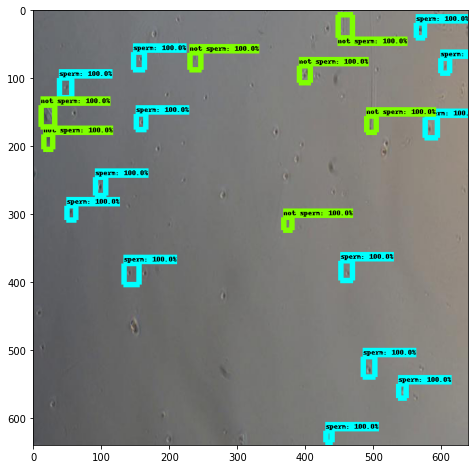

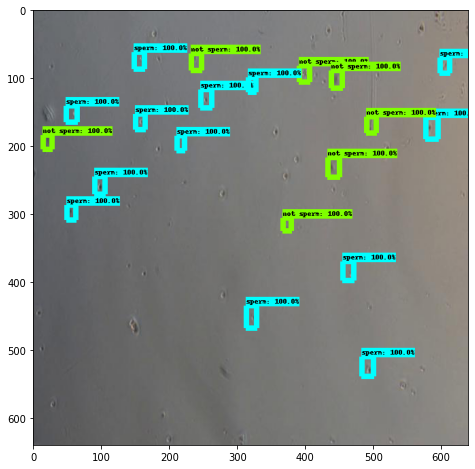

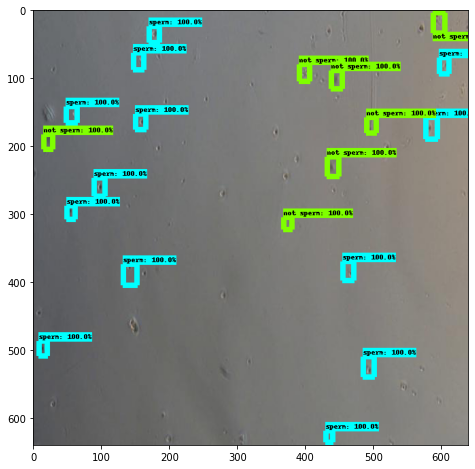

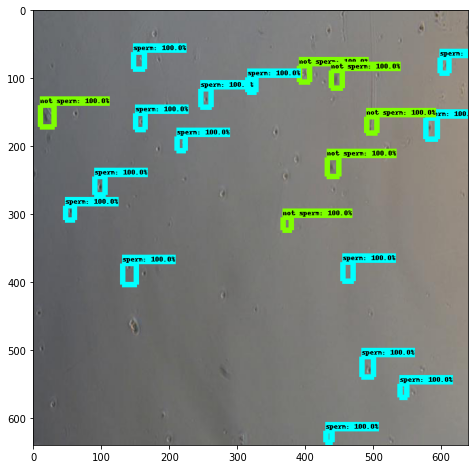

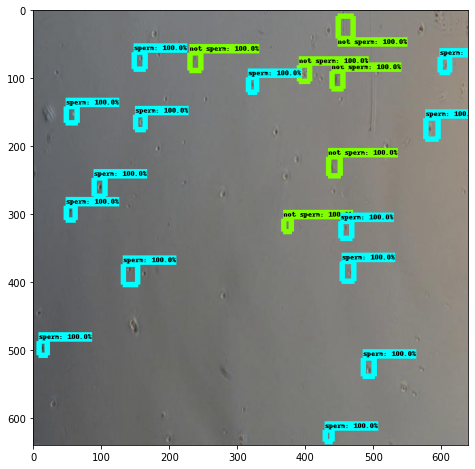

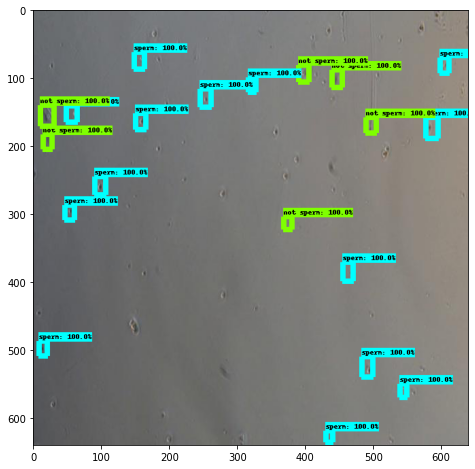

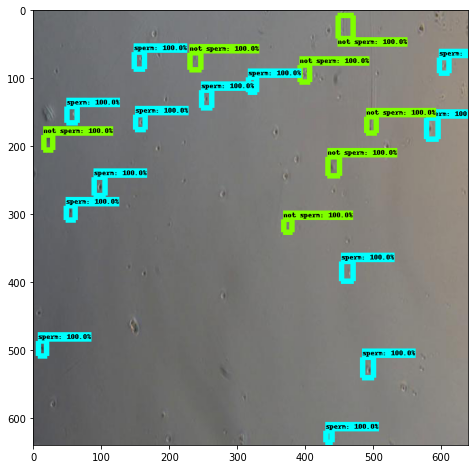

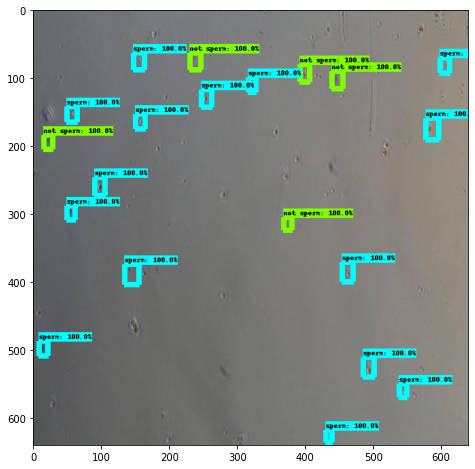

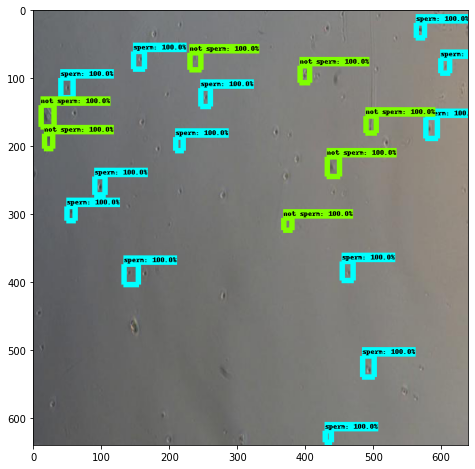

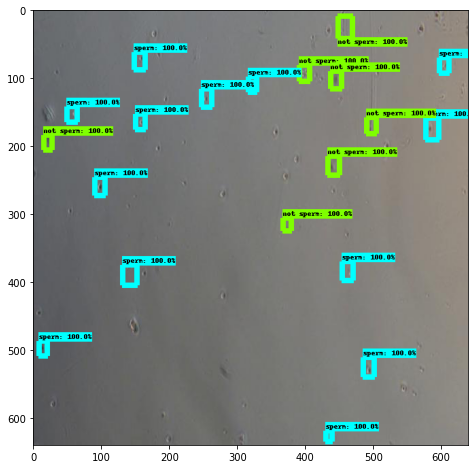

In [ ]:
plt.rcParams.update({'figure.max_open_warning': 0})
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

In [ ]:
!mkdir "/content/video4-ssd-80-20"
!cd "/content/video4-ssd-80-20"
!mkdir "/content/video4-ssd-80-20/eval_0"
!cp /content/models/research/fine_tuned_model/frozen_inference_graph.pb "/content/video4-ssd-80-20/frozen_inference_graph.pb"
!cp /content/models/research/training/events.out.tfevents.1609445109.8d8ab4e30842 "/content/video4-ssd-80-20"
!cp /content/models/research/training/eval_0/events.out.tfevents.1609445745.8d8ab4e30842 "/content/video4-ssd-80-20/eval_0"
!cp /content/tensorflow-object-detection-faster-rcnn/data/train/sperm_label_map.pbtxt "/content/video4-ssd-80-20"
!zip -r /content/video4-ssd-80-20 /content/video4-ssd-80-20

mkdir: cannot create directory ‘/content/video4-ssd-80-20’: File exists
mkdir: cannot create directory ‘/content/video4-ssd-80-20/eval_0’: File exists
  adding: content/video4-ssd-80-20/ (stored 0%)
  adding: content/video4-ssd-80-20/frozen_inference_graph.pb (deflated 10%)
  adding: content/video4-ssd-80-20/eval_0/ (stored 0%)
  adding: content/video4-ssd-80-20/eval_0/events.out.tfevents.1609445745.8d8ab4e30842 (deflated 80%)
  adding: content/video4-ssd-80-20/sperm_label_map.pbtxt (deflated 55%)
  adding: content/video4-ssd-80-20/events.out.tfevents.1609445109.8d8ab4e30842 (deflated 93%)


In [ ]:
from tensorflow.python.summary.summary_iterator import summary_iterator
a = 0
for event in summary_iterator('/content/models/research/training/events.out.tfevents.1607356412.a98a3e94939e'):
    for value in event.summary.value:
        print(value.tag)
        if value.tag == 'global_step/sec' and value.HasField('simple_value'):
          a += value.simple_value
print(a)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-d281085e2175>", line 3, in <module>
    for event in summary_iterator('/content/models/research/training/events.out.tfevents.1607356412.a98a3e94939e'):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/summary/summary_iterator.py", line 95, in summary_iterator
    return _SummaryIterator(path)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/summary/summary_iterator.py", line 31, in __init__
    self._tf_record_iterator = tf_record.tf_record_iterator(path)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py", line 340, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/lib/io/tf_record.py", line 171, in tf_record_iterator
    return _pywrap_record_io

NotFoundError: ignored

In [ ]:
# navigate to correct folder
%cd /content/tensorflow-object-detection/test

# call function to upload
upload_files()

[Errno 2] No such file or directory: '/content/tensorflow-object-detection/test'
/content/models/research/object_detection


In [ ]:
k = 0
while k < 100000000000000:
  k += 1

KeyboardInterrupt: ignored